In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Any

# Import the sparse attention components
from sparse_attention_hub.sparse_attention.research_attention import (
    ResearchAttention,
    ResearchAttentionConfig,
)
from sparse_attention_hub.sparse_attention.research_attention.maskers.fixed.implementations import (
    LocalMasker,
    LocalMaskerConfig,
    SinkMasker,
    SinkMaskerConfig,
)
from sparse_attention_hub.sparse_attention.base import SparseAttentionConfig

# Set up for visualization
plt.style.use('default')
sns.set_palette("husl")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✅ Imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


✅ Imports successful!
PyTorch version: 2.5.0
Device: cuda


In [2]:
# Configure the maskers
local_masker_config = LocalMaskerConfig(window_size=4)
sink_masker_config = SinkMaskerConfig(sink_size=2)

# Create the list of masker configs
masker_configs = [
    sink_masker_config,  # Apply sink masker first
    local_masker_config,  # Then apply local masker
]

print("Masker configurations:")
print(f"- LocalMasker: window_size={local_masker_config.window_size}")
print(f"- SinkMasker: sink_size={sink_masker_config.sink_size}")
print(f"- Total maskers: {len(masker_configs)}")

# Create the ResearchAttention configuration
research_attention_config = ResearchAttentionConfig(masker_configs=masker_configs)

print(f"\n✅ ResearchAttention configuration created with {len(research_attention_config.masker_configs)} maskers")


Masker configurations:
- LocalMasker: window_size=4
- SinkMasker: sink_size=2
- Total maskers: 2

✅ ResearchAttention configuration created with 2 maskers


In [3]:
# Initialize ResearchAttention from configuration
research_attention = ResearchAttention.create_from_config(research_attention_config)

print(f"✅ ResearchAttention initialized with {len(research_attention.maskers)} maskers:")
for i, masker in enumerate(research_attention.maskers):
    print(f"  {i+1}. {masker.__class__.__name__}")
    if hasattr(masker, 'sink_size'):
        print(f"     - sink_size: {getattr(masker, 'sink_size', 'N/A')}")
    if hasattr(masker, 'window_size'):
        print(f"     - window_size: {getattr(masker, 'window_size', 'N/A')}")

print(f"\nMasker types: {[type(m).__name__ for m in research_attention.maskers]}")


✅ ResearchAttention initialized with 2 maskers:
  1. SinkMasker
     - sink_size: 2
  2. LocalMasker
     - window_size: 4

Masker types: ['SinkMasker', 'LocalMasker']


In [4]:
# Define input dimensions
batch_size = 2
num_heads = 4
seq_len_queries = 8
seq_len_keys = 16
head_dim = 32

# Create random input tensors
queries = torch.randn(batch_size, num_heads, seq_len_queries, head_dim, device=device)
keys = torch.randn(batch_size, num_heads, seq_len_keys, head_dim, device=device)
values = torch.randn(batch_size, num_heads, seq_len_keys, head_dim, device=device)

# Optional: create a causal attention mask for demonstration
# (This is separate from the sparse attention masks created by our maskers)
attention_mask = None  # No additional mask for this example

print(f"Input tensor shapes:")
print(f"- Queries: {queries.shape}")
print(f"- Keys: {keys.shape}")
print(f"- Values: {values.shape}")
print(f"- Attention mask: {attention_mask}")

# Set attention parameters
scaling = 1.0 / (head_dim ** 0.5)  # Standard scaling for attention
dropout = 0.0  # No dropout for this example

print(f"\nAttention parameters:")
print(f"- Scaling factor: {scaling:.4f}")
print(f"- Dropout: {dropout}")


Input tensor shapes:
- Queries: torch.Size([2, 4, 8, 32])
- Keys: torch.Size([2, 4, 16, 32])
- Values: torch.Size([2, 4, 16, 32])
- Attention mask: None

Attention parameters:
- Scaling factor: 0.1768
- Dropout: 0.0


In [7]:
# Create a simple attention module for demonstration
# In practice, this would be your actual attention layer
class SimpleAttentionModule(torch.nn.Module):
    pass

module = SimpleAttentionModule()
module.eval()

# Run the sparse attention mechanism
print("Running sparse attention...")
attention_output, attention_weights = research_attention.custom_attention(
    module=module,
    queries=queries,
    keys=keys,
    values=values,
    attention_mask=attention_mask,
    scaling=scaling,
    dropout=dropout,
)

print(f"✅ Sparse attention completed!")
print(f"- Attention output shape: {attention_output.shape}")
print(f"- Attention weights shape: {attention_weights.shape if attention_weights is not None else 'None'}")
print(f"- Output device: {attention_output.device}")
print(f"- Output dtype: {attention_output.dtype}")

# Check for any NaN or Inf values
if torch.isnan(attention_output).any():
    print("⚠️  Warning: NaN values detected in attention output")
if torch.isinf(attention_output).any():
    print("⚠️  Warning: Inf values detected in attention output")

print(f"\nAttention output statistics:")
print(f"- Mean: {attention_output.mean().item():.4f}")
print(f"- Std: {attention_output.std().item():.4f}")
print(f"- Min: {attention_output.min().item():.4f}")
print(f"- Max: {attention_output.max().item():.4f}")


Running sparse attention...
✅ Sparse attention completed!
- Attention output shape: torch.Size([2, 8, 4, 32])
- Attention weights shape: torch.Size([2, 4, 8, 16])
- Output device: cuda:0
- Output dtype: torch.float32

Attention output statistics:
- Mean: 0.0129
- Std: 0.5362
- Min: -1.9573
- Max: 2.3813


Initial mask shape: (2, 4, 8, 16)
Initial mask is empty: True

After SinkMasker:
- Mask is empty: False
- Mask is full: False

After LocalMasker (final mask):
- Mask is empty: False
- Mask is full: False
- Final mask dense shape: torch.Size([2, 4, 8, 16])


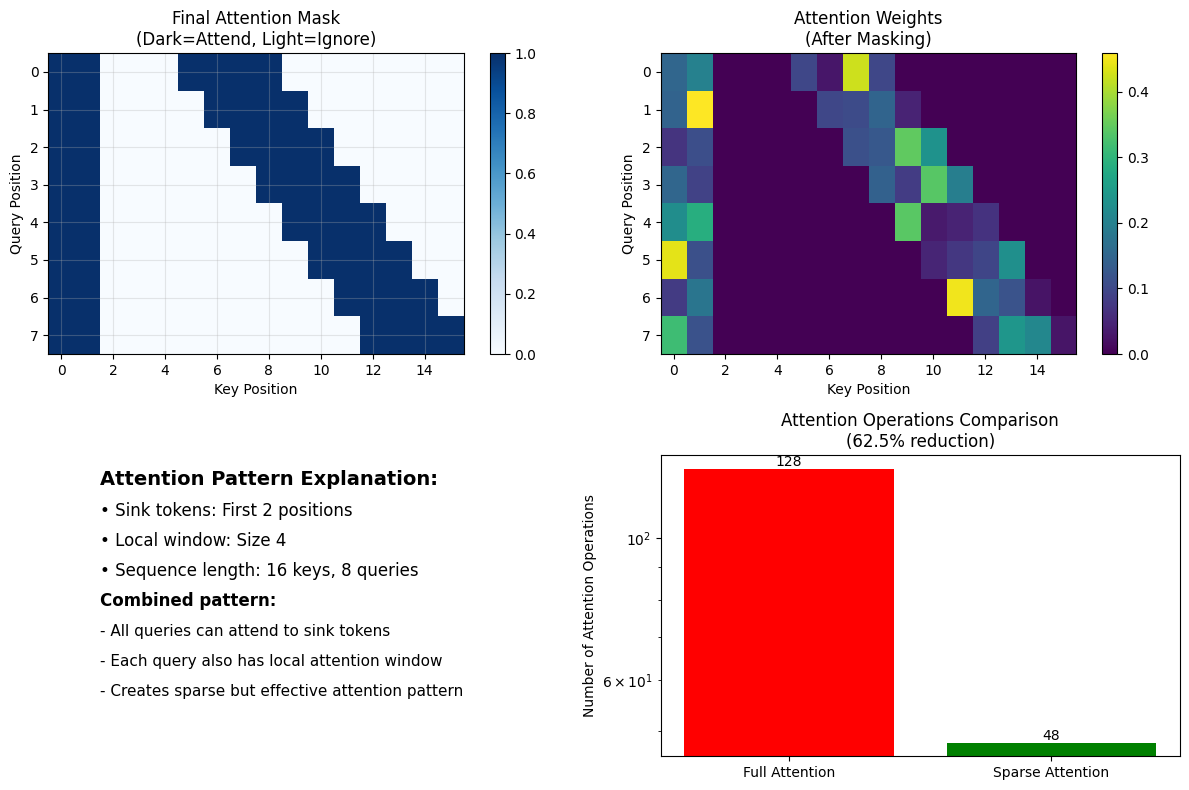


Efficiency metrics:
- Full attention operations: 128
- Sparse attention operations: 48
- Reduction: 62.5%
- Sparsity ratio: 0.375


In [8]:
# Let's manually trace through the masking process to see how it works
from sparse_attention_hub.sparse_attention.utils.mask import Mask

# Create an empty mask to start with
mask_shape = (batch_size, num_heads, seq_len_queries, seq_len_keys)
initial_mask = Mask.create_empty_mask(mask_shape)

print(f"Initial mask shape: {mask_shape}")
print(f"Initial mask is empty: {initial_mask.is_empty()}")

# Apply the SinkMasker
sink_masker = research_attention.maskers[0]  # First masker (SinkMasker)
mask_after_sink = sink_masker.add_mask(
    keys=keys,
    queries=queries,
    values=values,
    attention_mask=attention_mask,
    sparse_meta_data=None,
    previous_mask=initial_mask,
)

print(f"\nAfter SinkMasker:")
print(f"- Mask is empty: {mask_after_sink.is_empty()}")
print(f"- Mask is full: {mask_after_sink.is_full_mask()}")

# Apply the LocalMasker
local_masker = research_attention.maskers[1]  # Second masker (LocalMasker)
final_mask = local_masker.add_mask(
    keys=keys,
    queries=queries,
    values=values,
    attention_mask=attention_mask,
    sparse_meta_data=None,
    previous_mask=mask_after_sink,
)

print(f"\nAfter LocalMasker (final mask):")
print(f"- Mask is empty: {final_mask.is_empty()}")
print(f"- Mask is full: {final_mask.is_full_mask()}")

# Convert to dense mask for visualization
final_mask_dense = final_mask.get_dense_mask()
print(f"- Final mask dense shape: {final_mask_dense.shape}")

# Visualize the attention pattern for the first batch, first head
plt.figure(figsize=(12, 8))

# Plot the final attention mask
plt.subplot(2, 2, 1)
mask_to_plot = final_mask_dense[0, 0].cpu().numpy()  # First batch, first head
plt.imshow(mask_to_plot, cmap='Blues', aspect='auto')
plt.title('Final Attention Mask\n(Dark=Attend, Light=Ignore)')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.colorbar()

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Plot the attention weights if available
if attention_weights is not None:
    plt.subplot(2, 2, 2)
    weights_to_plot = attention_weights[0, 0].cpu().numpy()  # First batch, first head
    plt.imshow(weights_to_plot, cmap='viridis', aspect='auto')
    plt.title('Attention Weights\n(After Masking)')
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')
    plt.colorbar()

# Create a pattern explanation
plt.subplot(2, 2, 3)
plt.text(0.1, 0.9, 'Attention Pattern Explanation:', fontsize=14, weight='bold', transform=plt.gca().transAxes)
plt.text(0.1, 0.8, f'• Sink tokens: First {sink_masker_config.sink_size} positions', fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.7, f'• Local window: Size {local_masker_config.window_size}', fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.6, f'• Sequence length: {seq_len_keys} keys, {seq_len_queries} queries', fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.5, 'Combined pattern:', fontsize=12, weight='bold', transform=plt.gca().transAxes)
plt.text(0.1, 0.4, '- All queries can attend to sink tokens', fontsize=11, transform=plt.gca().transAxes)
plt.text(0.1, 0.3, '- Each query also has local attention window', fontsize=11, transform=plt.gca().transAxes)
plt.text(0.1, 0.2, '- Creates sparse but effective attention pattern', fontsize=11, transform=plt.gca().transAxes)
plt.axis('off')

# Plot efficiency comparison
plt.subplot(2, 2, 4)
full_attention_ops = seq_len_queries * seq_len_keys
sparse_attention_ops = torch.sum(final_mask_dense[0, 0]).item()
efficiency = (1 - sparse_attention_ops / full_attention_ops) * 100

plt.bar(['Full Attention', 'Sparse Attention'], [full_attention_ops, sparse_attention_ops], color=['red', 'green'])
plt.title(f'Attention Operations Comparison\n({efficiency:.1f}% reduction)')
plt.ylabel('Number of Attention Operations')
plt.yscale('log')

for i, v in enumerate([full_attention_ops, sparse_attention_ops]):
    plt.text(i, v, f'{int(v)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\nEfficiency metrics:")
print(f"- Full attention operations: {full_attention_ops}")
print(f"- Sparse attention operations: {int(sparse_attention_ops)}")
print(f"- Reduction: {efficiency:.1f}%")
print(f"- Sparsity ratio: {sparse_attention_ops / full_attention_ops:.3f}")


In [ ]:
# Quick experiment: Try different configurations
print("🧪 Quick Experiment: Different Masker Configurations")
print("="*60)

# Configuration 1: Only SinkMasker
config1 = ResearchAttentionConfig(masker_configs=[SinkMaskerConfig(sink_size=4)])
attention1 = ResearchAttention.create_from_config(config1)

# Configuration 2: Only LocalMasker
config2 = ResearchAttentionConfig(masker_configs=[LocalMaskerConfig(window_size=6)])
attention2 = ResearchAttention.create_from_config(config2)

# Configuration 3: Local + Sink (reverse order)
config3 = ResearchAttentionConfig(masker_configs=[
    LocalMaskerConfig(window_size=3),
    SinkMaskerConfig(sink_size=3)
])
attention3 = ResearchAttention.create_from_config(config3)

configs = [
    ("Sink Only (size=4)", attention1),
    ("Local Only (window=6)", attention2),
    ("Local→Sink (3,3)", attention3),
    ("Sink→Local (2,4)", research_attention)  # Our original configuration
]

# Compare sparsity patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (name, attention) in enumerate(configs):
    # Create masks
    mask_shape = (1, 1, seq_len_queries, seq_len_keys)
    initial_mask = Mask.create_empty_mask(mask_shape)
    
    # Apply maskers
    current_mask = initial_mask
    for masker in attention.maskers:
        current_mask = masker.add_mask(
            keys=keys[:1, :1],  # Use first batch and head only
            queries=queries[:1, :1],
            values=values[:1, :1],
            attention_mask=None,
            sparse_meta_data=None,
            previous_mask=current_mask,
        )
    
    # Plot
    mask_dense = current_mask.get_dense_mask()
    axes[i].imshow(mask_dense[0, 0].cpu().numpy(), cmap='Blues', aspect='auto')
    axes[i].set_title(f'{name}\nSparsity: {torch.sum(mask_dense[0, 0]).item()}/{seq_len_queries * seq_len_keys}')
    axes[i].set_xlabel('Key Position')
    axes[i].set_ylabel('Query Position')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Experiment completed! Try modifying the configurations above to explore different patterns.")
print("💡 Tip: The order of maskers matters - they build upon each other sequentially.")
